In [ ]:
"""# Libraries"""
## Data manipulation and analysis
import numpy as np
import pandas as pd
from joblib import dump, load

## Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

## signal processing
import mne
from sklearn.decomposition import PCA, FastICA
from mne.decoding import CSP
from scipy import signal
from scipy.signal import butter, lfilter, filtfilt
from scipy.linalg import eigh

## Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

In [ ]:
"""# parameters"""

fs = 250
freq = 50
order = 4
lowcut = 8
highcut = 30
quality = 30
n_components = 4
n_components_pca = 16
n_components_ica = 16
n_components_csp = 4

In [ ]:
"""## load data"""

data = pd.read_csv('Data/eeg-motor-imagery-bciciv-2a/BCICIV_2a_all_patients.csv')

In [ ]:
"""## data overview"""

data.head()
print('shape:', data.shape)
print('columns:', data.columns)
print('info:', data.info())
print('describe:\n', data.describe())
print('missing values:\n', data.isnull().sum())

"""## label unique values"""

print('unique labels:', data['label'].unique())
print('unique labels count:', data['label'].value_counts())

"""- there is no missing values in the data
- there is no gap in the range of the data
- there are 4 labels: right hand, left hand, feet and tongue
"""

shape: (492048, 26)
columns: Index(['patient', 'time', 'label', 'epoch', 'EEG-Fz', 'EEG-0', 'EEG-1',
       'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 'EEG-C3', 'EEG-6', 'EEG-Cz',
       'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9', 'EEG-10', 'EEG-11', 'EEG-12',
       'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492048 entries, 0 to 492047
Data columns (total 26 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   patient  492048 non-null  int64  
 1   time     492048 non-null  float64
 2   label    492048 non-null  object 
 3   epoch    492048 non-null  int64  
 4   EEG-Fz   492048 non-null  float64
 5   EEG-0    492048 non-null  float64
 6   EEG-1    492048 non-null  float64
 7   EEG-2    492048 non-null  float64
 8   EEG-3    492048 non-null  float64
 9   EEG-4    492048 non-null  float64
 10  EEG-5    492048 non-null  float64
 11  EEG-C3   492048 non-null  float64
 12  EEG-6    49

'- there is no missing values in the data\n- there is no gap in the range of the data\n- there are 4 labels: right hand, left hand, feet and tongue\n'

In [ ]:
"""# Preprocessing

## Encoding
"""

data['label'] = data['label'].map({'right': 1, 'left': 2, 'foot': 3, 'tongue': 4})

In [ ]:
"""## EEG preprocessing functions

### bandpass filter
"""

def bandpass_filter(data, lowcut=8, highcut=30, fs=250, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

"""### notch filter"""

def notch_filter(data, freq=50, fs=250, quality=30):
    b, a = signal.iirnotch(freq, quality, fs)
    return filtfilt(b, a, data, axis=0)

In [ ]:
"""## prepare data"""

X = data.drop('label', axis=1).values
y = data['label'].values

print("\nInitial class distribution:")
unique_labels, counts = np.unique(y, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Class {label}: {count} samples")

"""## Reshape data into trials"""

samples_per_trial = 100  # Changed from 1000 to 100
n_trials = X.shape[0] // samples_per_trial
X = X[:n_trials * samples_per_trial]
y = y[:n_trials * samples_per_trial]
y_labels = y[::samples_per_trial]
X_reshaped = X.reshape(n_trials, samples_per_trial, -1).transpose(0, 2, 1)

print("\nAfter reshaping:")
print(f"Number of trials: {n_trials}")
print(f"Samples per trial: {samples_per_trial}")
print(f"X_reshaped shape: {X_reshaped.shape}")
print(f"y_labels shape: {y_labels.shape}")

print("\nClass distribution after reshaping:")
unique_labels, counts = np.unique(y_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Class {label}: {count} trials")


Initial class distribution:
Class 1: 130248 samples
Class 2: 130248 samples
Class 3: 115776 samples
Class 4: 115776 samples

After reshaping:
Number of trials: 4920
Samples per trial: 100
X_reshaped shape: (4920, 25, 100)
y_labels shape: (4920,)

Class distribution after reshaping:
Class 1: 1301 trials
Class 2: 1304 trials
Class 3: 1156 trials
Class 4: 1159 trials


In [ ]:
"""## apply EEG preprocessing"""

print("Applying bandpass filter...")
filtered_data = bandpass_filter(X_reshaped)
print("Applying notch filter...")
filtered_data = notch_filter(filtered_data)

print("\nData shape after preprocessing:", filtered_data.shape)
print("Class distribution after preprocessing:")
unique_labels, counts = np.unique(y_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Class {label}: {count} trials")

Applying bandpass filter...
Applying notch filter...

Data shape after preprocessing: (4920, 25, 100)
Class distribution after preprocessing:
Class 1: 1301 trials
Class 2: 1304 trials
Class 3: 1156 trials
Class 4: 1159 trials


In [ ]:
"""## remove EOG with PCA"""

n_trials, n_channels, n_samples = filtered_data.shape
# Reshape to preserve temporal information
data_2d = filtered_data.reshape(n_trials, n_channels, n_samples)

# Apply PCA to each time point
pca_data = np.zeros((n_trials, n_components_pca, n_samples))
pca = PCA(n_components=n_components_pca)

# First flatten the data for PCA
flattened_data = data_2d.reshape(n_trials * n_samples, n_channels)
# Fit PCA on all data
pca.fit(flattened_data)

# Transform each time point
for t in range(n_samples):
    time_data = data_2d[:, :, t]
    pca_data[:, :, t] = pca.transform(time_data)

print(f"\nPCA data shape: {pca_data.shape}")
print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_):.2%}")

print("\nData shape after PCA:", pca_data.shape)
print("Class distribution after PCA:")
unique_labels, counts = np.unique(y_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Class {label}: {count} trials")

# print (pca.explained_variance_)
print (pca.explained_variance_ratio_)
print (pca.explained_variance_ratio_.cumsum())


PCA data shape: (4920, 16, 100)
Total variance explained: 99.72%

Data shape after PCA: (4920, 16, 100)
Class distribution after PCA:
Class 1: 1301 trials
Class 2: 1304 trials
Class 3: 1156 trials
Class 4: 1159 trials
[9.23826936e-01 2.92539727e-02 2.14019596e-02 7.69297389e-03
 4.50607844e-03 2.84343044e-03 1.59735223e-03 1.33272032e-03
 1.10196543e-03 9.30670751e-04 6.78807948e-04 4.60552308e-04
 4.19879546e-04 4.06789877e-04 3.97943846e-04 3.75262057e-04]
[0.92382694 0.95308091 0.97448287 0.98217584 0.98668192 0.98952535
 0.9911227  0.99245542 0.99355739 0.99448806 0.99516687 0.99562742
 0.9960473  0.99645409 0.99685203 0.9972273 ]



Generating individual plots for each feature's PCA contributions...


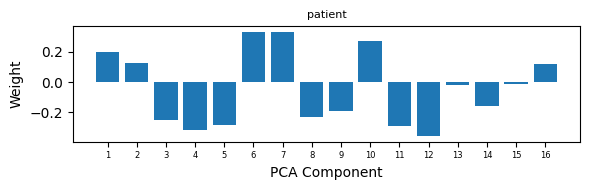

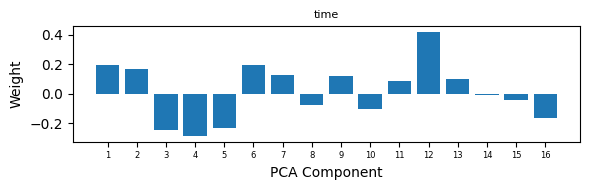

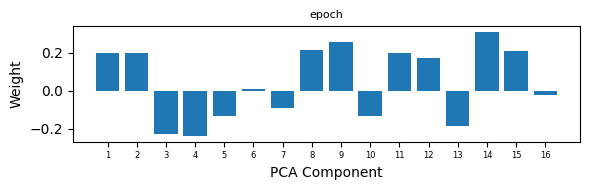

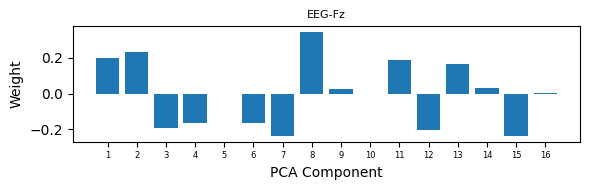

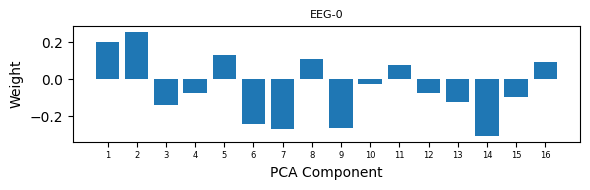

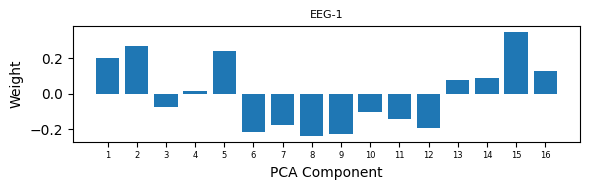

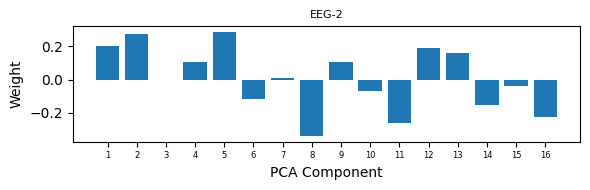

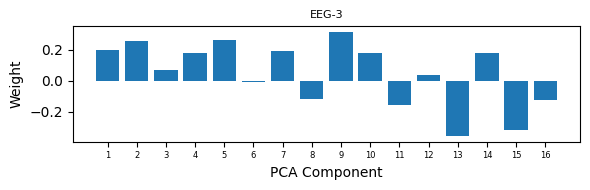

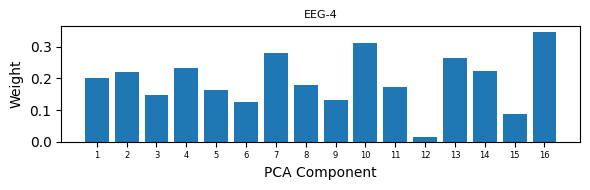

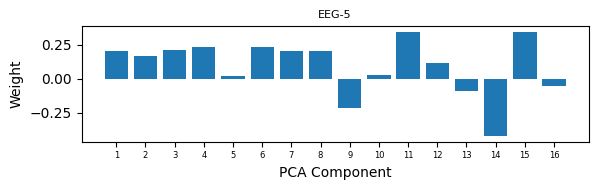

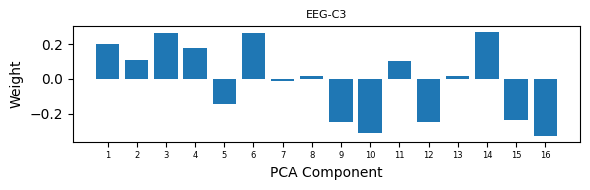

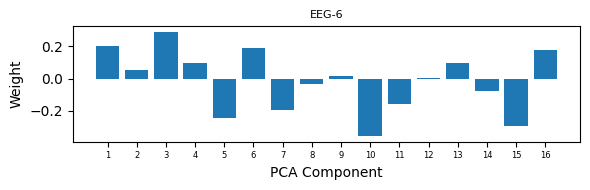

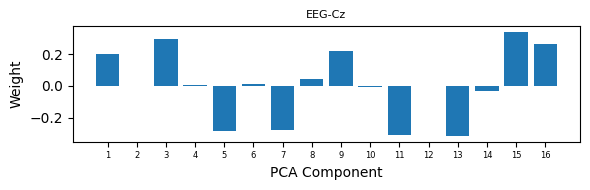

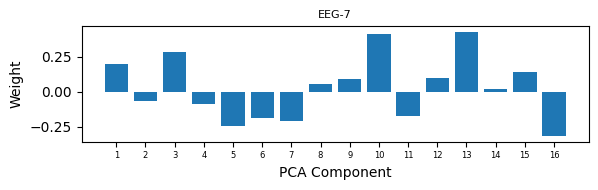

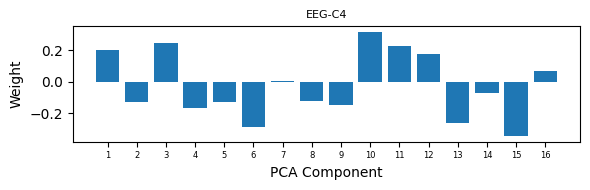

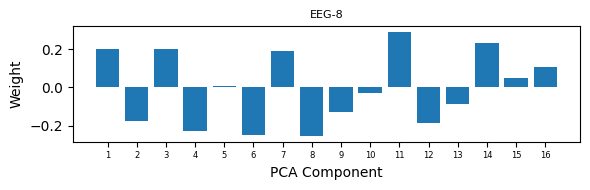

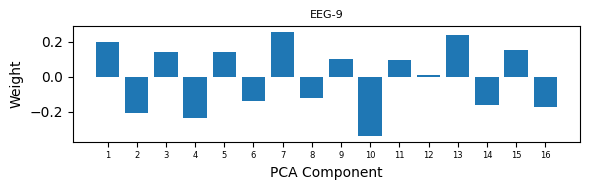

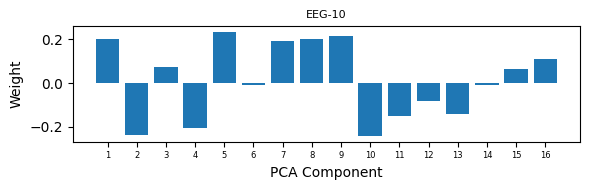

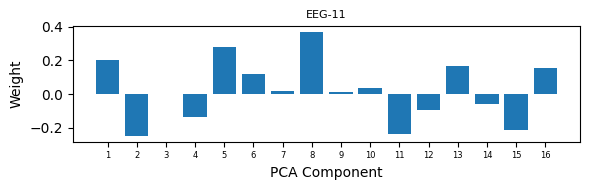

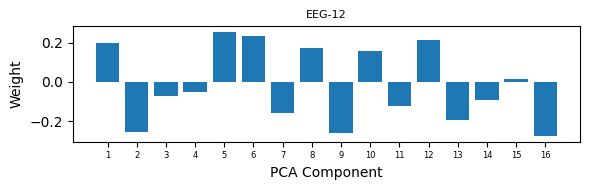

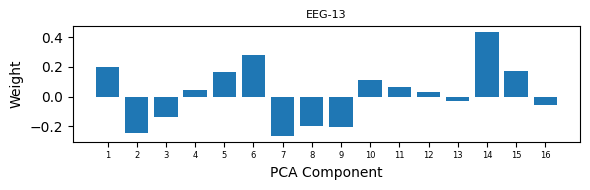

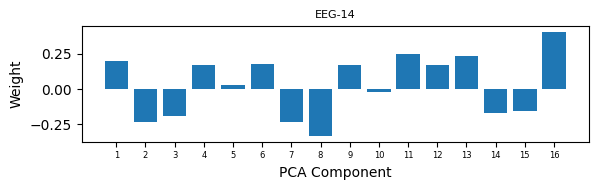

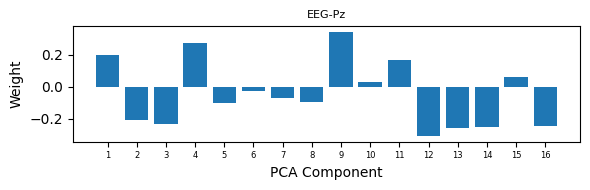

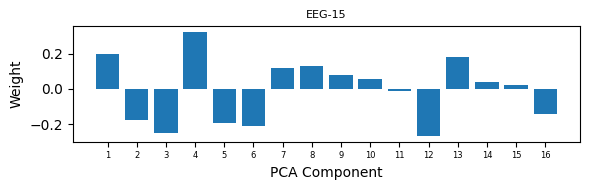

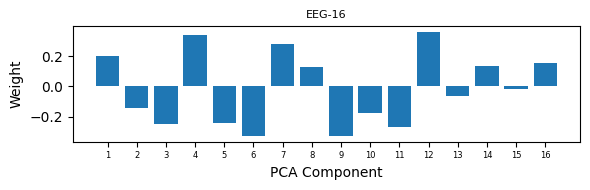

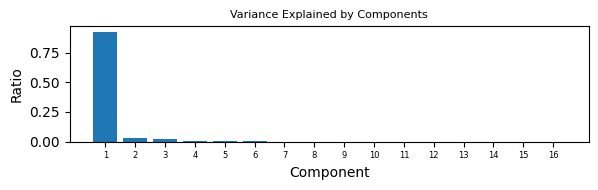

In [ ]:
"""### Plot PCA components"""
# Get column names (features)
feature_names = data.drop('label', axis=1).columns.tolist()

# Plot each column's contribution to PCA components separately
print("\nGenerating individual plots for each feature's PCA contributions...")
for col_idx, col_name in enumerate(feature_names):
    plt.figure(figsize=(6, 2))  # Made even smaller for better visibility
    # Get contribution of this column to each PCA component
    contributions = [pca.components_[i][col_idx] for i in range(n_components_pca)]
    plt.bar(range(n_components_pca), contributions)
    plt.title(f'{col_name}', fontsize=8)
    plt.xlabel('PCA Component')
    plt.ylabel('Weight')
    plt.xticks(range(n_components_pca), [f'{i+1}' for i in range(n_components_pca)], fontsize=6)
    plt.tight_layout()
    plt.show()
    plt.close()  # Close the figure to free memory
    
# Plot variance explained by each component
plt.figure(figsize=(6, 2))
plt.bar(range(n_components_pca), pca.explained_variance_ratio_)
plt.title('Variance Explained by Components', fontsize=8)
plt.xlabel('Component')
plt.ylabel('Ratio')
plt.xticks(range(n_components_pca), [f'{i+1}' for i in range(n_components_pca)], fontsize=6)
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
"""## apply ICA"""

print("\nApplying ICA...")
# Reshape for ICA while preserving temporal information
ica_input = pca_data.reshape(n_trials * n_samples, n_components_pca)
ica = FastICA(n_components=n_components_ica, random_state=42)
ica_data = ica.fit_transform(ica_input)

print("\nData shape after ICA:", ica_data.shape)
print("Class distribution after ICA:")
unique_labels, counts = np.unique(y_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Class {label}: {count} trials")


Applying ICA...

Data shape after ICA: (492000, 16)
Class distribution after ICA:
Class 1: 1301 trials
Class 2: 1304 trials
Class 3: 1156 trials
Class 4: 1159 trials


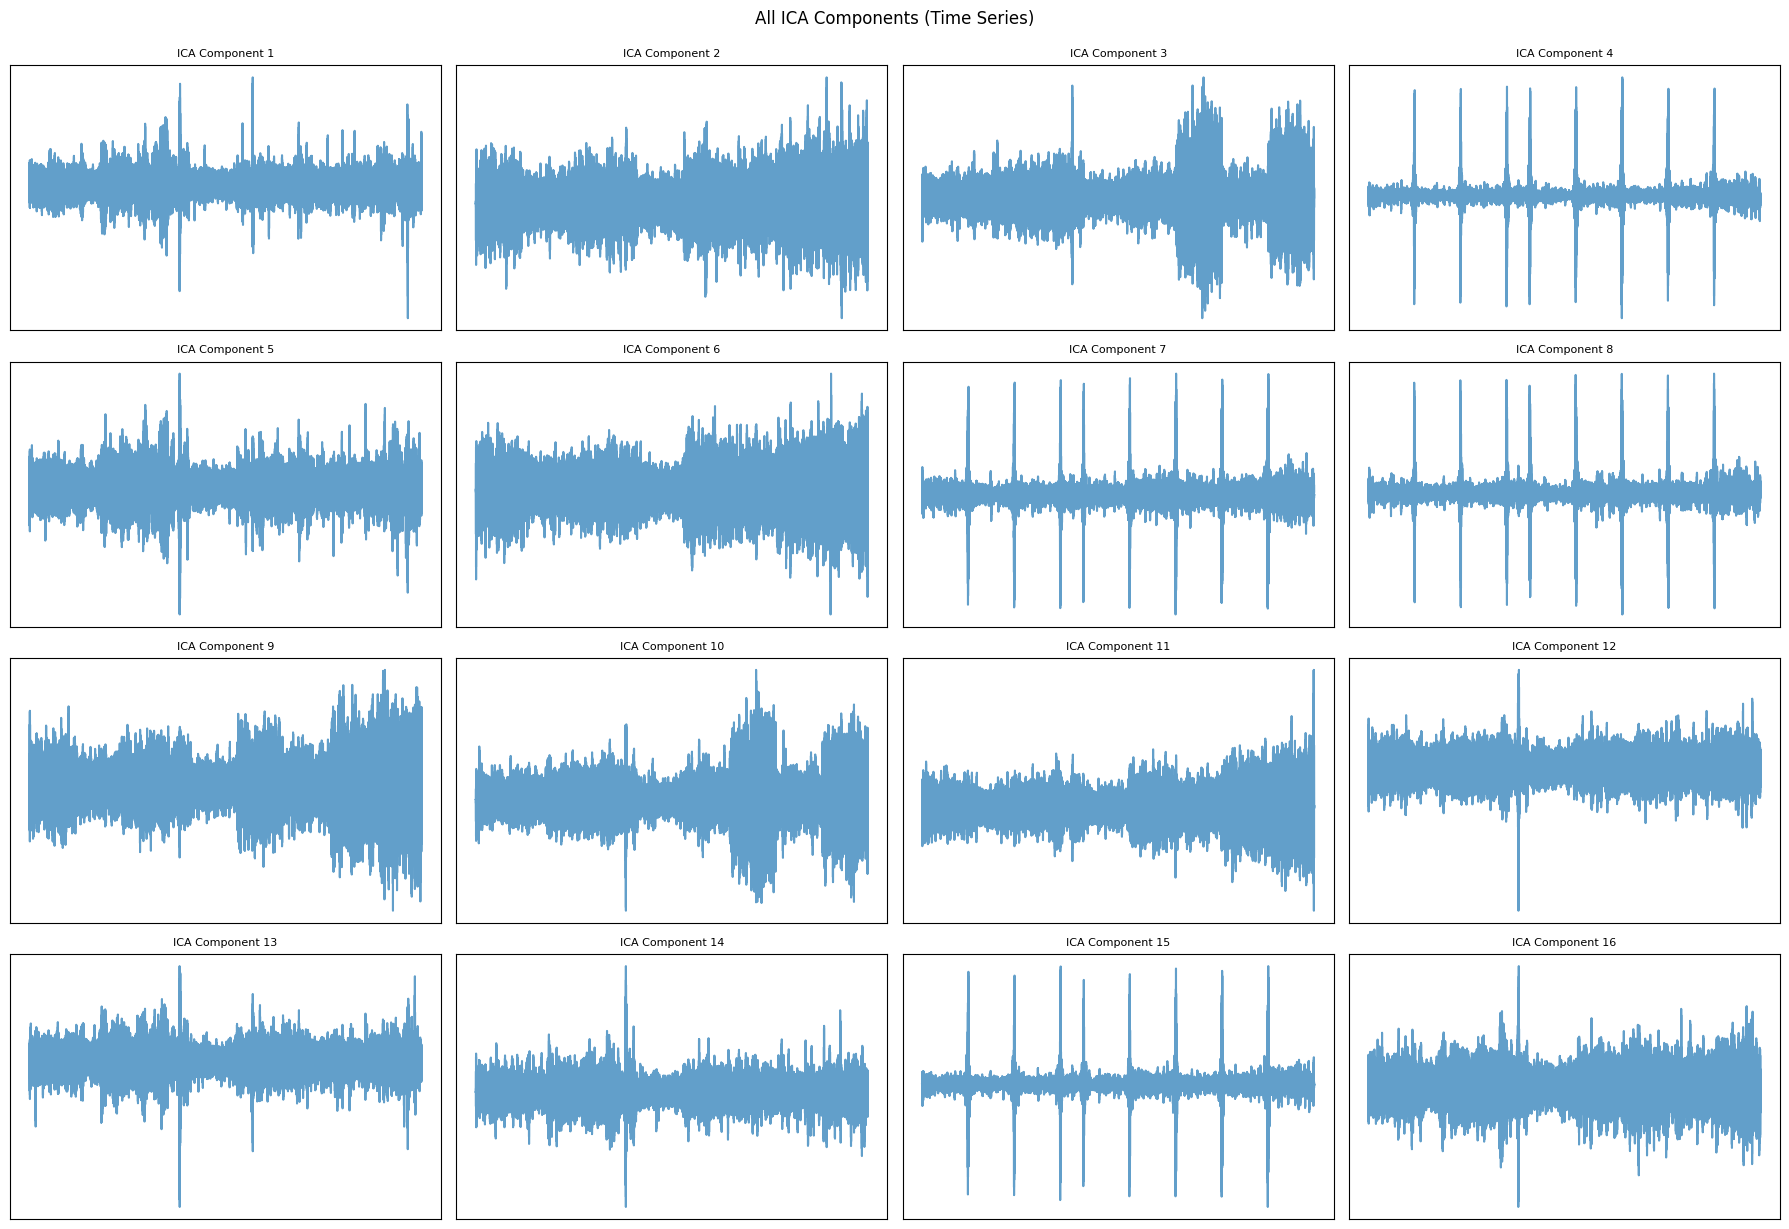

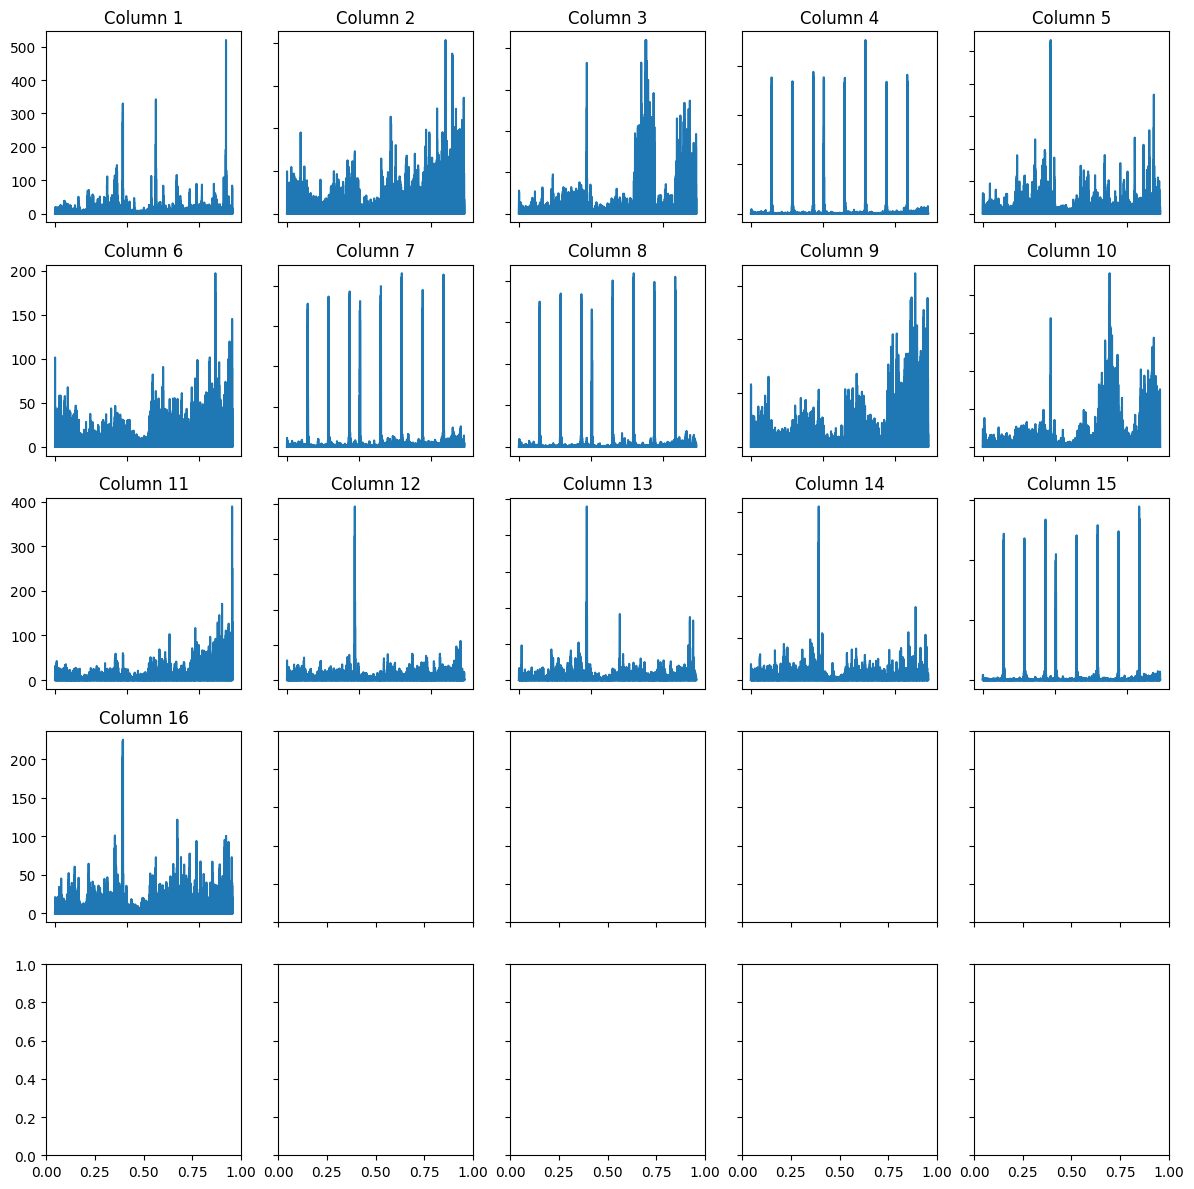

In [ ]:
"""### plot all ICA components"""
plt.figure(figsize=(18, 12))
n_cols = 4
n_rows = int(np.ceil(n_components_ica / n_cols))
for i in range(n_components_ica):
    plt.subplot(n_rows, n_cols, i+1)
    plt.plot(ica_data[:, i], alpha=0.7)
    plt.title(f'ICA Component {i+1}', fontsize=8)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.suptitle('All ICA Components (Time Series)', y=1.02)
plt.show()

fig, ax = plt.subplots(5, 5, figsize=(12, 12))  # Adjusted for 16 columns
row = 0
col = 0
count = 0

# Assuming you have the column names in a list called `column_names`
column_names = [f"Column {i+1}" for i in range(n_components_ica)]  # Replace with actual column names if available

for i in range(n_components_ica):
    ax[row, col].plot(ica_data[:, i]**2)
    ax[row, col].set_title(column_names[i])
    count += 1
    col += 1
    if count % 5 == 0:
        row += 1
        col = 0

for ax in fig.get_axes():
    ax.label_outer()

fig.tight_layout()

In [ ]:
"""### reshape ICA data"""
# Reshape back to maintain temporal structure
ica_data_reshaped = ica_data.reshape(n_trials, n_samples, n_components_ica)
# Transpose to get (trials, channels, samples)
ica_data_reshaped = np.transpose(ica_data_reshaped, (0, 2, 1))

print(f"ICA data shape after reshaping: {ica_data_reshaped.shape}")

# Verify dimensions
if ica_data_reshaped.shape[1] == n_components_ica:
    print("Success! ICA data has exactly 16 components")
else:
    print(f"Warning: ICA data has {ica_data_reshaped.shape[1]} components instead of 16")

# Use ica_data_reshaped for CSP extraction
cleaned_data = ica_data_reshaped

ICA data shape after reshaping: (4920, 16, 100)
Success! ICA data has exactly 16 components


In [ ]:
"""## Extract CSP features"""

print("Extracting CSP features...")
# Data validation
print(f"Shape of cleaned_data before any processing: {cleaned_data.shape}")
print(f"Shape of y_labels: {y_labels.shape}")
print("Unique values in y_labels before processing:", np.unique(y_labels, return_counts=True))

# Initialize CSP
csp = CSP(n_components=n_components_csp, reg=None, log=True, norm_trace=False)

# Make sure data is in the correct shape (trials, channels, samples)
if cleaned_data.shape[1] != n_components_ica:
    cleaned_data = np.transpose(cleaned_data, (0, 2, 1))
print(f"Data shape before CSP: {cleaned_data.shape}")

# Verify there are trials for each class
for class_id in range(1, 5):  # Now checking all 4 classes
    n_trials = np.sum(y_labels == class_id)
    print(f"Number of trials for class {class_id}: {n_trials}")

# Additional check to make sure data and labels align
assert len(cleaned_data) == len(y_labels), "Number of trials doesn't match number of labels"
assert not np.any(np.isnan(cleaned_data)), "Data contains NaN values"
assert not np.any(np.isinf(cleaned_data)), "Data contains infinite values"

# Fit and transform the data
csp_features = csp.fit_transform(cleaned_data, y_labels)

print("CSP feature extraction completed")
print("\nFeature Information:")
print("CSP Features shape:", csp_features.shape)

Extracting CSP features...
Shape of cleaned_data before any processing: (4920, 16, 100)
Shape of y_labels: (4920,)
Unique values in y_labels before processing: (array([1, 2, 3, 4]), array([1301, 1304, 1156, 1159]))
Data shape before CSP: (4920, 16, 100)
Number of trials for class 1: 1301
Number of trials for class 2: 1304
Number of trials for class 3: 1156
Number of trials for class 4: 1159
Computing rank from data with rank=None
    Using tolerance 1.6 (2.2e-16 eps * 16 dim * 4.6e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4 (2.2e-16 eps * 16 dim * 4e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with 


Visualizing CSP patterns...


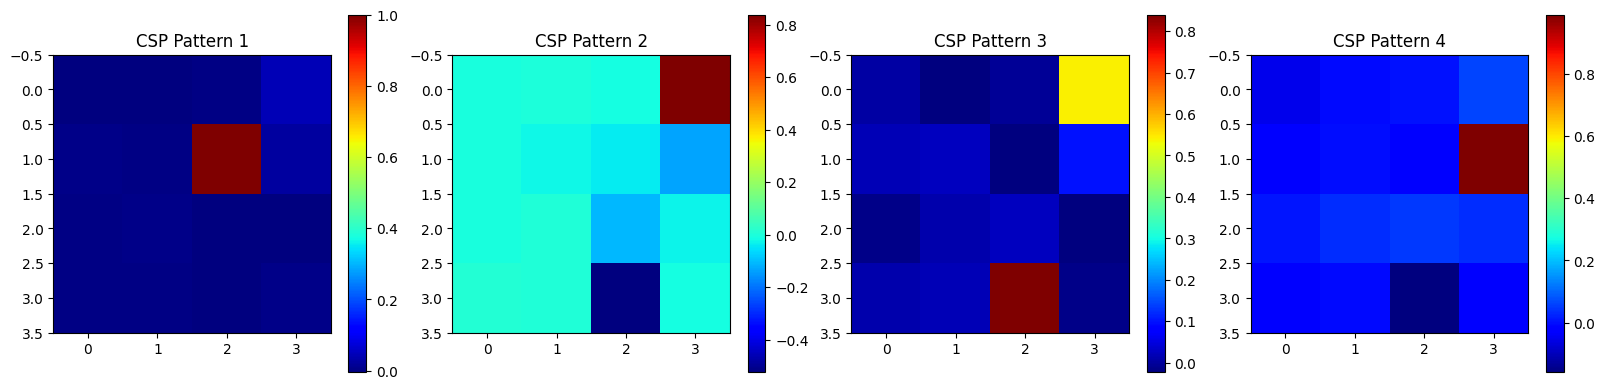

In [ ]:
"""# Visualizing CSP patterns"""
print("\nVisualizing CSP patterns...")
patterns = csp.patterns_
patterns_norm = patterns / np.max(np.abs(patterns))

plt.figure(figsize=(16, 4))
class_names = ['Right Hand', 'Left Hand', 'Feet', 'Tongue']  # Updated class names for all 4 classes
for i in range(min(4, n_components_csp)):  # Show patterns for all 4 classes
    plt.subplot(1, 4, i + 1)
    plt.imshow(patterns_norm[i].reshape(4, 4), cmap='jet', interpolation='nearest')
    plt.title(f'CSP Pattern {i+1}')
    plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
"""## Save preprocessed data and features"""

np.save('preprocessed_data.npy', cleaned_data)
np.save('csp_features.npy', csp_features)

print("\nPreprocessed data and features saved successfully")


Preprocessed data and features saved successfully


In [ ]:
"""# Model"""

"""## Load preprocessed data and features"""

cleaned_data = np.load('preprocessed_data.npy')
csp_features = np.load('csp_features.npy')

"""## Split data into training and testing sets"""

print("\nBefore training:")
print(f"CSP features shape: {csp_features.shape}")
print(f"Labels shape: {y_labels.shape}")
print("\nClass distribution in full dataset:")
unique_labels, counts = np.unique(y_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Class {label}: {count} samples")

X_train, X_test, y_train, y_test = train_test_split(csp_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

print("\nTraining set:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print("\nClass distribution in training set:")
unique_labels, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Class {label}: {count} samples")

print("\nTest set:")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print("\nClass distribution in test set:")
unique_labels, counts = np.unique(y_test, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Class {label}: {count} samples")


Before training:
CSP features shape: (4920, 4)
Labels shape: (4920,)

Class distribution in full dataset:
Class 1: 1301 samples
Class 2: 1304 samples
Class 3: 1156 samples
Class 4: 1159 samples

Training set:
X_train shape: (3936, 4)
y_train shape: (3936,)

Class distribution in training set:
Class 1: 1041 samples
Class 2: 1043 samples
Class 3: 925 samples
Class 4: 927 samples

Test set:
X_test shape: (984, 4)
y_test shape: (984,)

Class distribution in test set:
Class 1: 260 samples
Class 2: 261 samples
Class 3: 231 samples
Class 4: 232 samples


In [ ]:
"""## SVM Model"""

# Try different kernels
kernels = ['linear', 'rbf', 'poly']
best_accuracy = 0
best_kernel = None

for kernel in kernels:
    print(f"\nTraining SVM with {kernel} kernel...")
    svm = SVC(kernel=kernel, random_state=42)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy with {kernel} kernel: {accuracy:.4f}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_kernel = kernel

print(f"\nBest kernel: {best_kernel} with accuracy: {best_accuracy:.4f}")

# Train final model with best kernel
svm = SVC(kernel=best_kernel, random_state=42)
svm.fit(X_train, y_train)


Training SVM with linear kernel...
Accuracy with linear kernel: 0.2856

Training SVM with rbf kernel...
Accuracy with rbf kernel: 0.2602

Training SVM with poly kernel...
Accuracy with poly kernel: 0.2734

Best kernel: linear with accuracy: 0.2856


SVC(kernel='linear', random_state=42)

In [ ]:
"""## Save test data and model for later evaluation"""
print("\nSaving test data and model...")
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)
dump(svm, 'svm_model.joblib')
print("Test data and model saved successfully")


Saving test data and model...
Test data and model saved successfully
